# Tutorial for Event-Related Potential (ERP) computing

Authors: Daniel Falcon, Renato Paredes
Laboratorio de Neurociencia Cognitiva Computacional - Departamento de Psicología, Pontificia Universidad Católica del Perú

This tutorial is based on [MNE-Python](https://mne.tools/stable/auto_tutorials/index.html).

## Environment setup

In [ ]:
!pip install mne
!wget https://github.com/renatoparedes/Neuro-PUCP/blob/main/EEG/sample_data.edf

In [3]:
import mne

## Load data

In [4]:
# Load data
raw = mne.io.read_raw_edf("sample_data.edf", stim_channel="MarkerType", preload=True)

# Select channels
raw.pick_channels(
    [
        "Cz",
        "Fz",
        "Fp1",
        "F3",
        "FT7",
        "CP3",
        "P7",
        "O1",
        "Pz",
        "Oz",
        "O2",
        "P8",
        "CP4",
        "FT8",
        "F4",
        "Fp2",
        "MarkerType",
    ]
)
raw.info

Extracting EDF parameters from /home/renato/Neuro-PUCP/EEG/sample_data.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 160127  =      0.000 ...  1250.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<Info | 8 non-empty values
 bads: []
 ch_names: Cz, Fz, Fp1, F3, FT7, CP3, P7, O1, Pz, Oz, O2, P8, CP4, FT8, F4, ...
 chs: 16 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: 2023-12-15 10:18:58 UTC
 nchan: 17
 projs: []
 sfreq: 128.0 Hz
 subject_info: 1 item (dict)
>

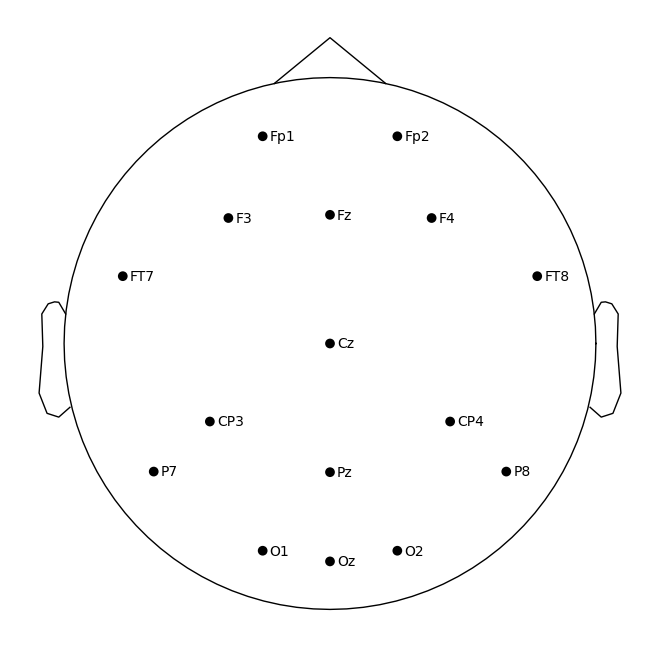

In [5]:
# Specify montage
easycap_montage = mne.channels.make_standard_montage("easycap-M1")
raw.set_montage(easycap_montage)

# Show montage
fig = raw.plot_sensors(show_names=True)

## EEG data pre-processing

In [6]:
# All EEG data were first bandpass filtered from 0.1 to 30 Hz.
l_freq = 0.1
h_freq = 30
raw.filter(l_freq, h_freq)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 4225 samples (33.008 s)



<RawEDF | sample_data.edf, 17 x 160128 (1251.0 s), ~20.8 MB, data loaded>

In [7]:
# Data were then re-referenced to the common average before continuing with paradigm-specific processing.
raw.set_eeg_reference("average")

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | sample_data.edf, 17 x 160128 (1251.0 s), ~20.8 MB, data loaded>

In [33]:
# We removed eye-blink artefacts using independent component analysis (ICA). See: https://mne.tools/stable/help/migrating.html
from mne.preprocessing import ICA

# Random state refers to SEED.
ica = ICA(n_components=5, max_iter="auto", random_state=97)
ica.fit(raw)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.5s.


Method,fastica
Fit,14 iterations on raw data (160128 samples)
ICA components,5
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


In [34]:
explained_var_ratio = ica.get_explained_variance_ratio(raw)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )

Fraction of eeg variance explained by all components: 0.8777705570795818


In [35]:
component_number = 0
explained_var_ratio = ica.get_explained_variance_ratio(
    raw, components=[component_number]
)

print(
    f"Fraction of variance explained by component #{component_number}:",
    explained_var_ratio["eeg"],
)

Fraction of variance explained by component #0: 0.23481113306091606


Creating RawArray with float64 data, n_channels=5, n_times=160128
    Range : 0 ... 160127 =      0.000 ...  1250.992 secs
Ready.


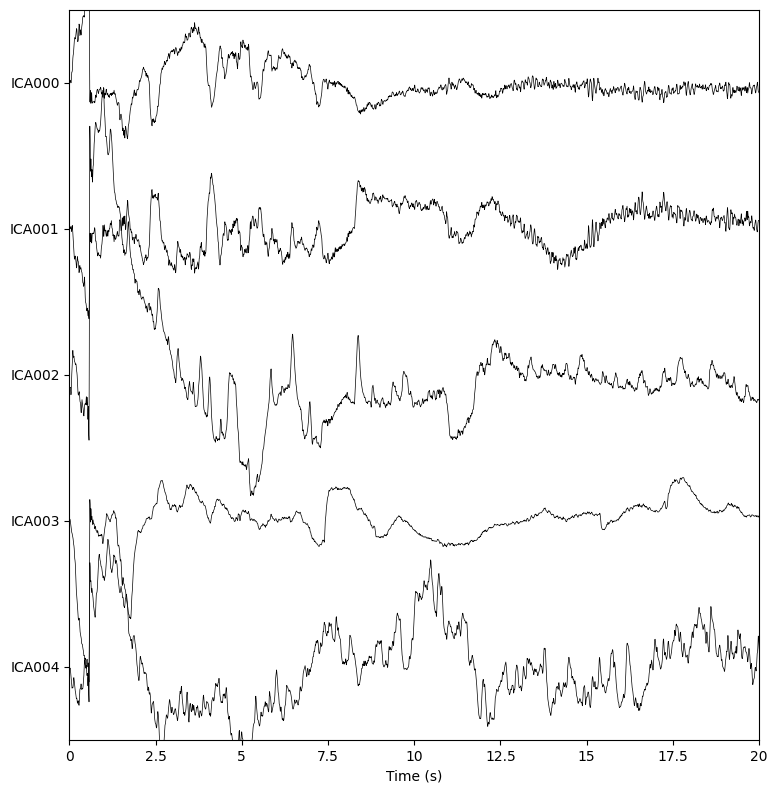

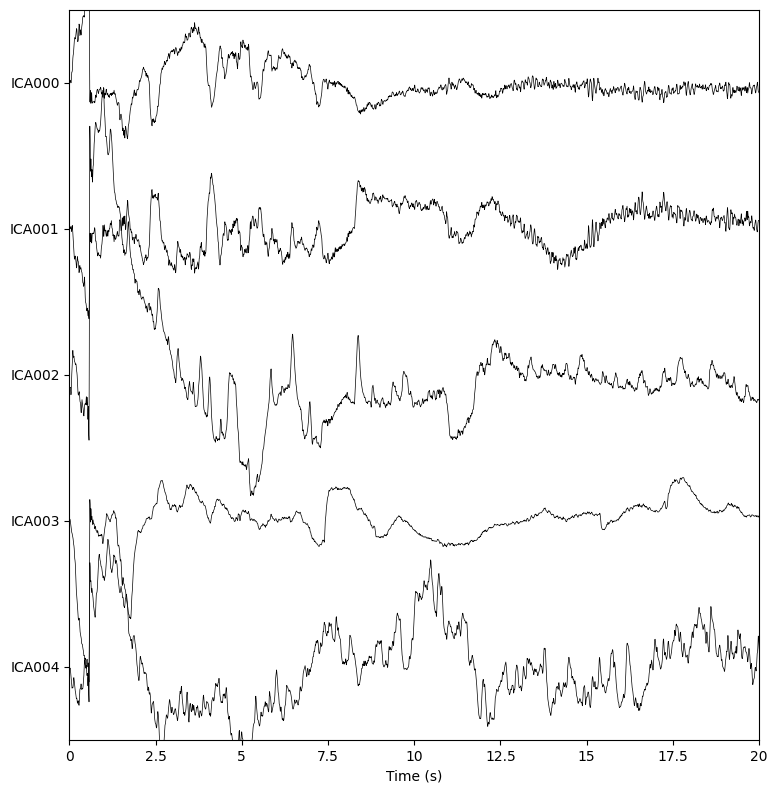

In [36]:
# Show indepedent components
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

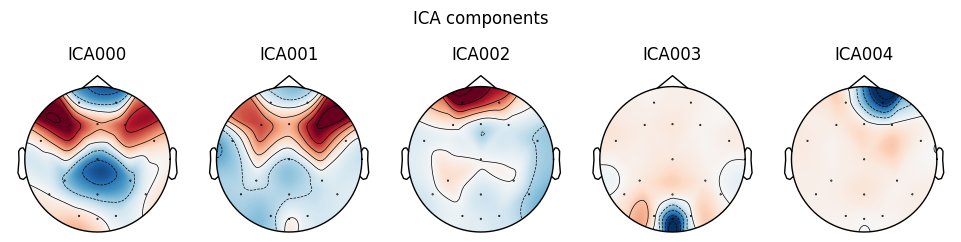

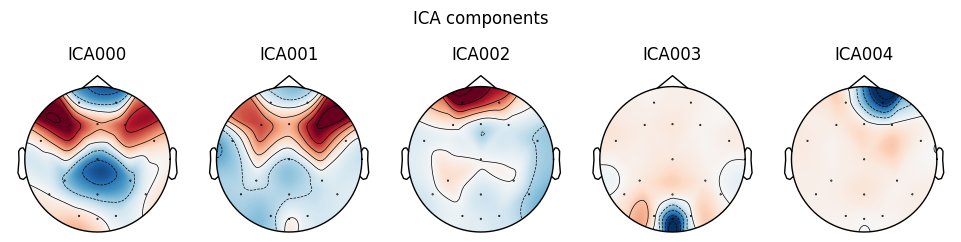

In [37]:
ica.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
625 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
625 matching events found
No baseline correction applied
0 projection items activated


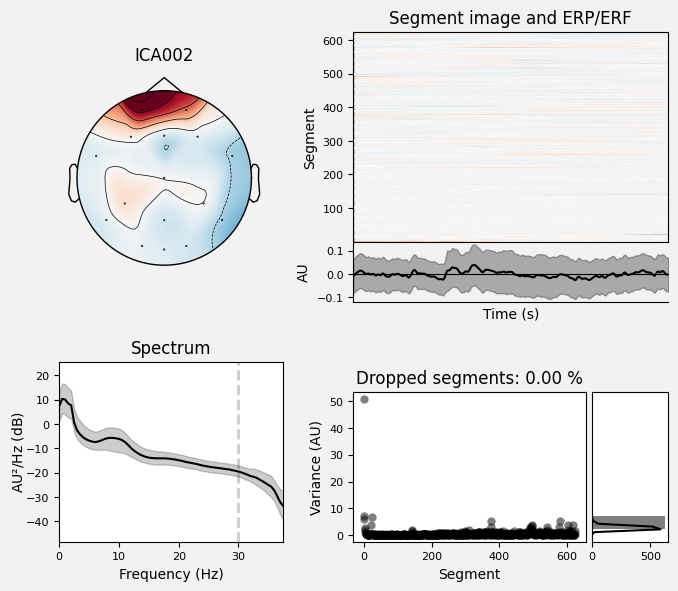

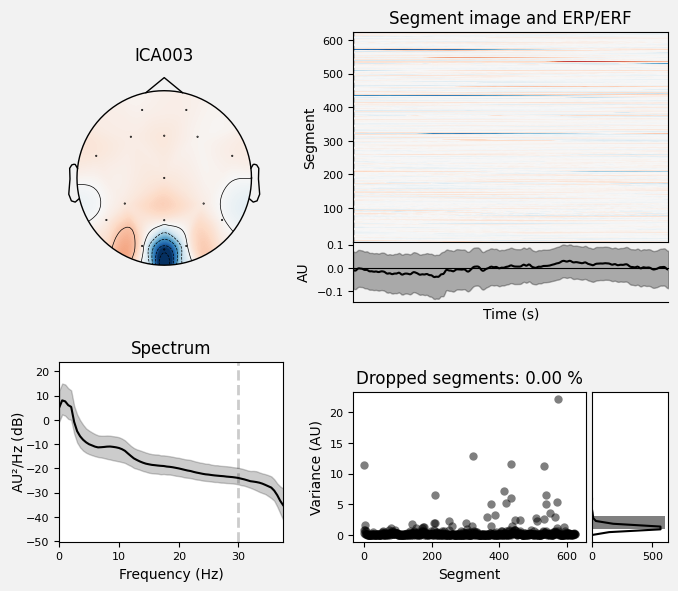

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [41]:
# Explore components of interest
ica.plot_properties(raw, picks=[2, 3])

A guide on how to identify artifact components from ICA: https://labeling.ucsd.edu/tutorial/labels

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 16 PCA components


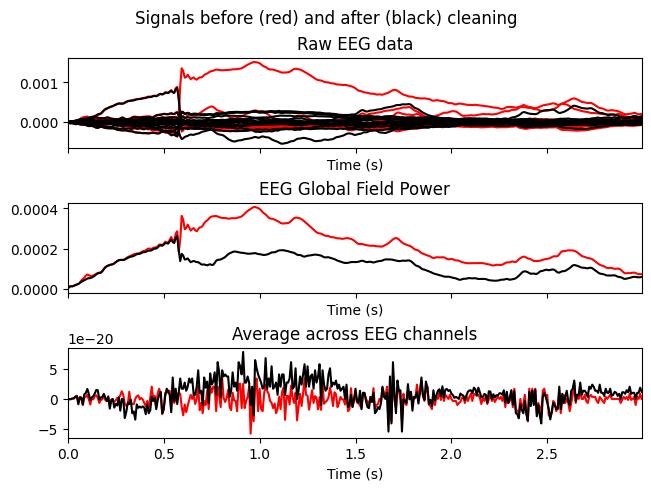

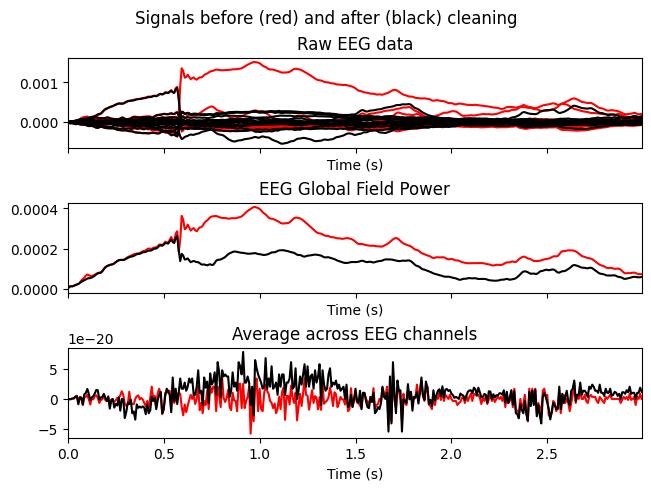

In [42]:
# Show EEG signals before and after removing a component
ica.plot_overlay(raw, exclude=[2], picks="eeg")

In [43]:
# Exclude the desired component
ica.exclude = [2]

In [44]:
# Reconstrct the signal after removing the desired component
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 16 PCA components


<RawEDF | sample_data.edf, 17 x 160128 (1251.0 s), ~20.8 MB, data loaded>

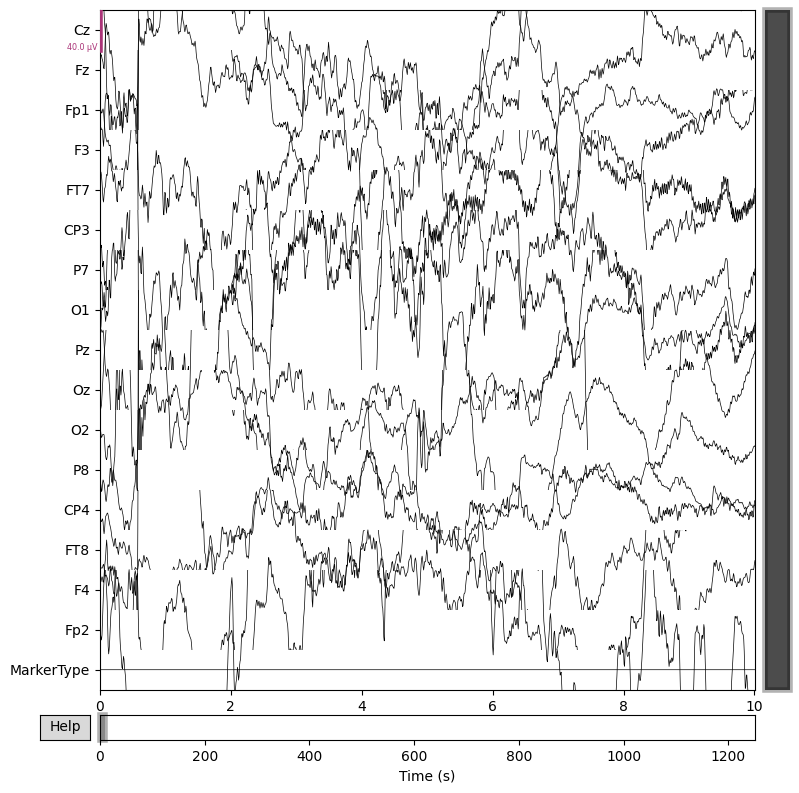

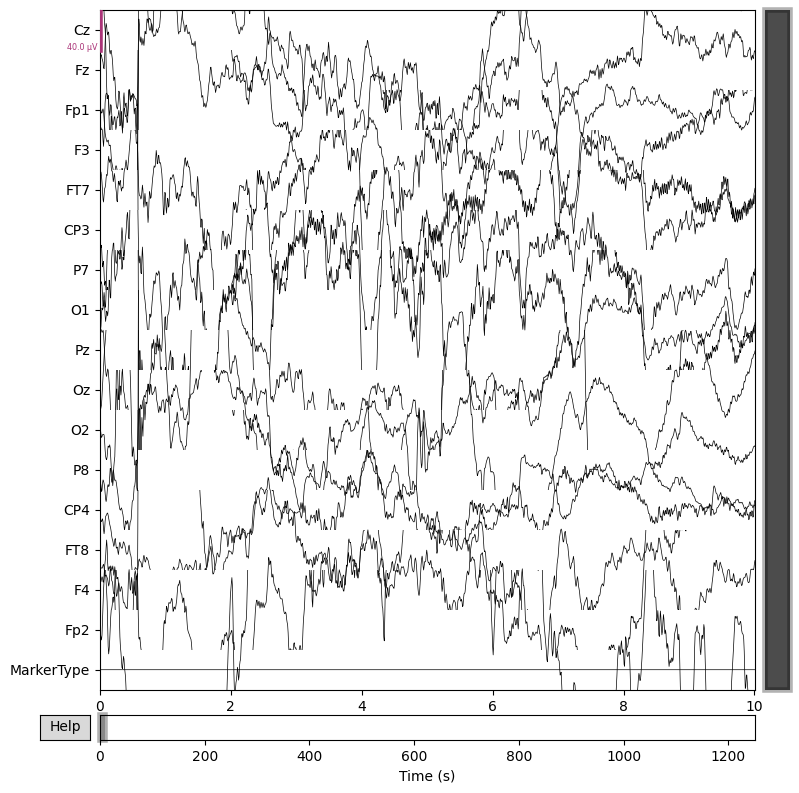

In [45]:
# Show reconstructed signal
reconst_raw.plot()

## Epoching

86 events found
Event IDs: [1]


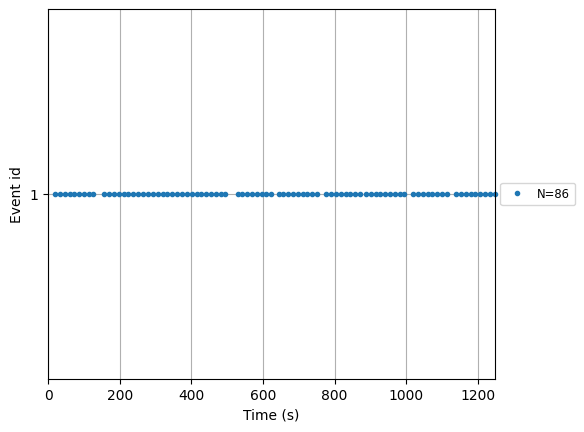

In [46]:
# Find events in the dataset
events = mne.find_events(reconst_raw)

# Plot events
fig = mne.viz.plot_events(
    events, sfreq=raw.info["sfreq"], first_samp=reconst_raw.first_samp
)

In [47]:
# The pruned data were then epoched from −100 ms to 700 ms relative to stimulus onset.
# Each epoch was baseline corrected from −100 ms to 0 ms.
# Epochs with PTP amplitude values ±150 mV were excluded.

epochs = mne.Epochs(
    reconst_raw,
    events,
    tmin=-0.1,
    tmax=0.7,
    baseline=(-0.1, 0),
    reject=dict(eeg=150e-6),
)

Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


Using data from preloaded Raw for 86 events and 104 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['F3', 'F4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F3', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'F4']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3', 'O1', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'Oz', 'F4']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['Fz', 'F4']
    Rejecting  epoch based on EE

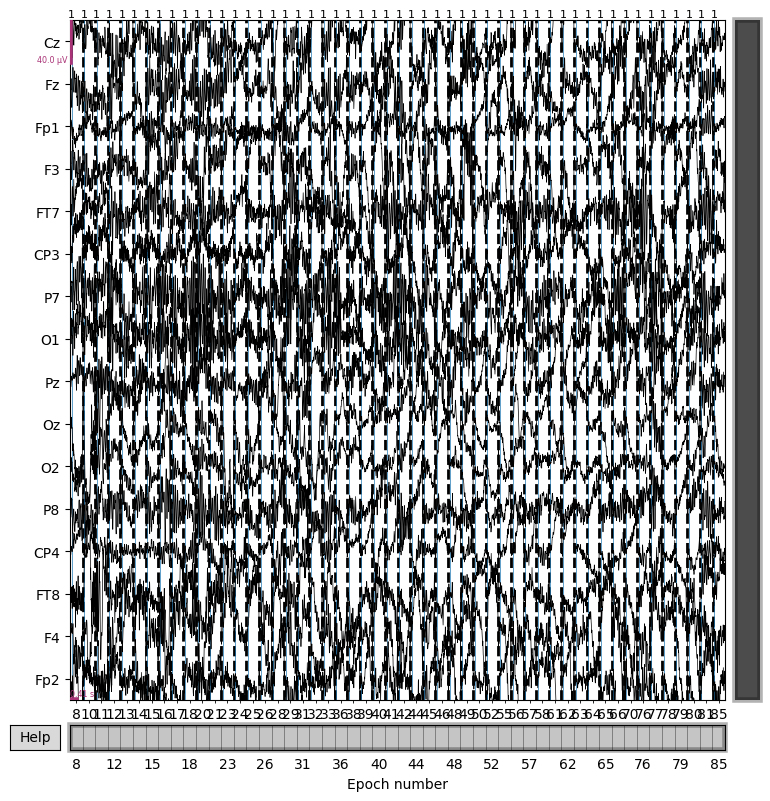

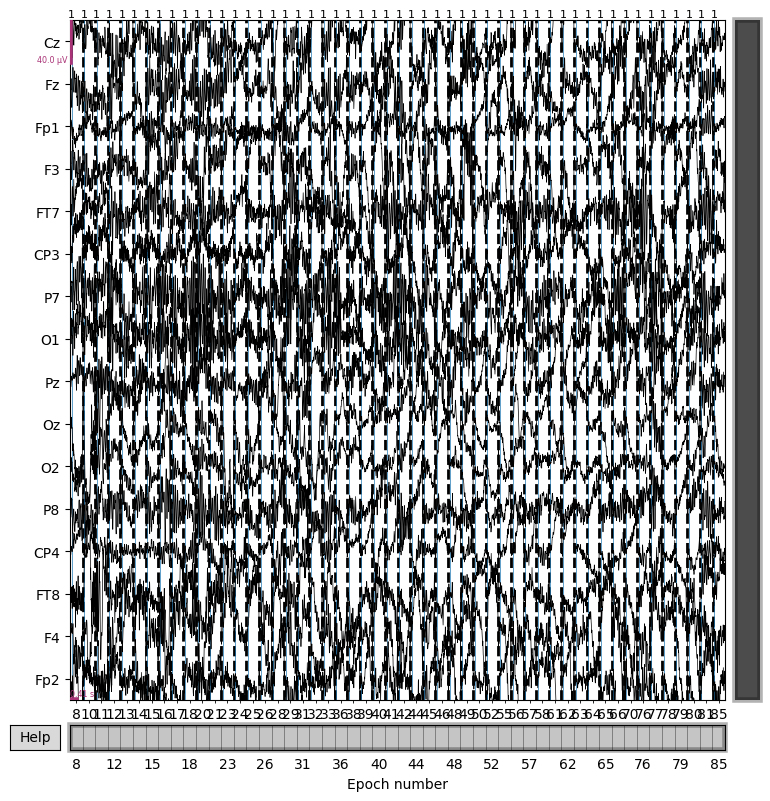

In [48]:
epochs.plot(n_epochs=86, events=True)

## ERP calculation

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


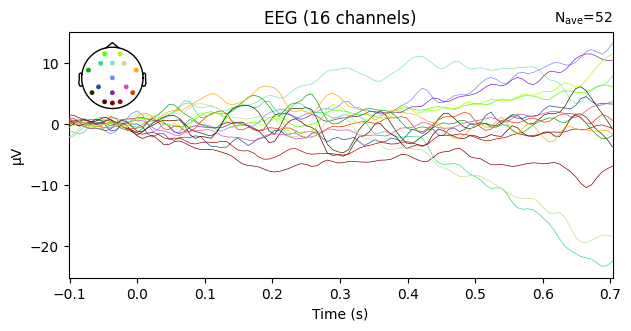

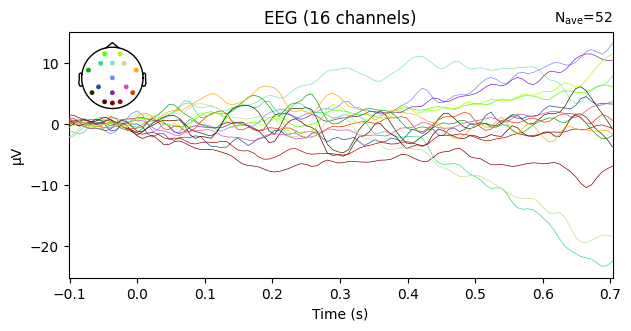

In [84]:
# We then averaged accepted epochs to create ERP waveforms for both standard and deviant tones.
evoked = epochs.average()
evoked.plot()

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


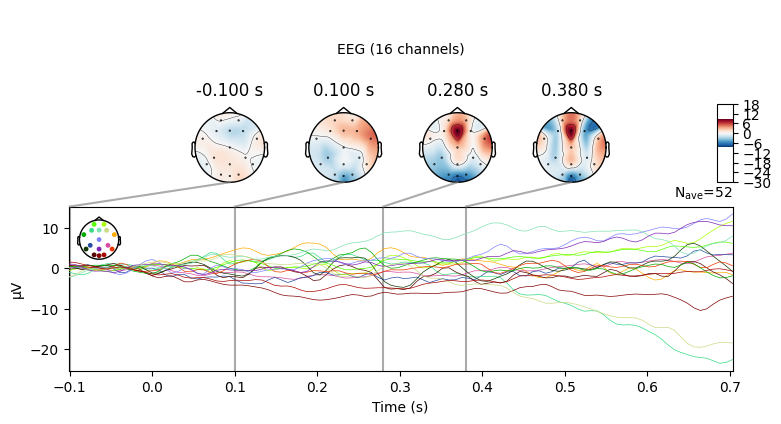

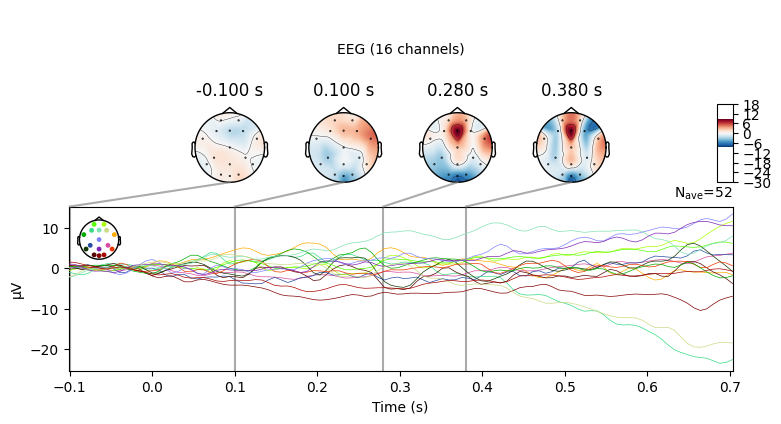

In [85]:
# Plot times of interest
evoked.plot_joint(times=[-0.1, 0.1, 0.28, 0.38])

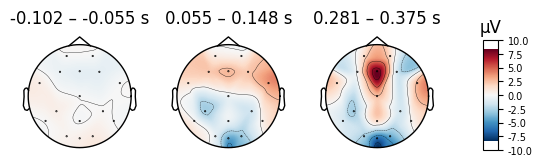

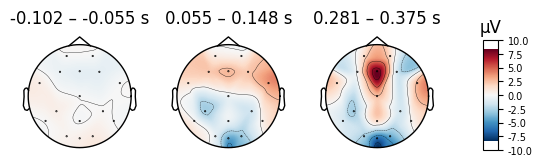

In [86]:
# Plot topographic map of times of interest
evoked.plot_topomap(times=[-0.1, 0.1, 0.33], average=0.1)

Not setting metadata
52 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_4578/773739861.py:2: RuntimeWarning: Only one channel in group "Fz"; cannot combine by method "mean".
  epochs.plot_image(picks="Fz", combine="mean")


combining channels using "mean"


/tmp/ipykernel_4578/773739861.py:2: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  epochs.plot_image(picks="Fz", combine="mean")


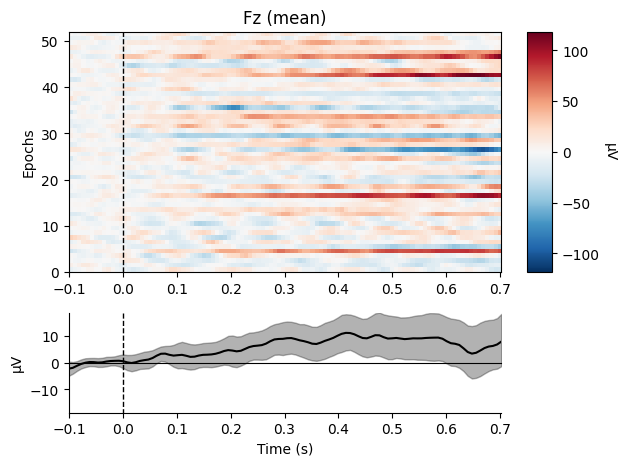

[<Figure size 640x480 with 3 Axes>]

In [87]:
# Plot ERP per channel
epochs.plot_image(picks="Fz", combine="mean")

In [83]:
# We calculated the P300 peak for each EEG system as the average waveform value over the pre-determined time window of 280–380 ms following stimulus onset.
epochs.load_data()
evoked_window = epochs.copy().average().crop(tmin=0.280, tmax=0.380)
evoked_channel = evoked_window.pick("Pz")
evoked_channel.get_peak(return_amplitude=True)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


('Pz', 0.34375, 2.076524283611792e-06)